In [1]:
# Cell 1 — Imports and constants
import os
from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paths
ROOT = Path.cwd()
DATA_CANDIDATES = [
    ROOT / "amazon_delivery_with_history.csv",
    ROOT / "amazon_delivery_cleaned.csv",
    ROOT / "amazon_delivery.csv"
]
OUT_DIR = ROOT / "analysis_outputs"
OUT_DIR.mkdir(exist_ok=True)
MODELS = {
    "lgbm_history_tuned": ROOT / "lgbm_history_tuned.joblib",
    "lgbm_native_cat_booster": ROOT / "lgbm_native_cat_model_booster.joblib",
    "lgbm_tuned_model": ROOT / "lgbm_tuned_model.joblib",
    "baseline_lr": ROOT / "baseline_lr_model.joblib",
    "lgbm_optuna_native": ROOT / "lgbm_optuna_native.joblib"
}
CATEGORY_LEVELS_PATH = ROOT / "category_levels.json"
PIPELINE_PATH = ROOT / "preprocessor_pipeline.joblib"   
IMPUTER_PATH = ROOT / "preprocessor_imputer.joblib"     
SCALER_PATH = ROOT / "preprocessor_scaler.joblib"       

print("Working dir:", ROOT)
print("Output dir:", OUT_DIR)

Working dir: C:\Users\shail_u9zs758
Output dir: C:\Users\shail_u9zs758\analysis_outputs


In [2]:
# Cell 2 — Load holdout / test set
data_path = None
for p in DATA_CANDIDATES:
    if p.exists():
        data_path = p
        break
if data_path is None:
    raise FileNotFoundError("No dataset found. Place amazon_delivery_with_history.csv or amazon_delivery_cleaned.csv in the project folder.")
df = pd.read_csv(data_path)
print("Loaded data:", data_path, "shape:", df.shape)

Loaded data: C:\Users\shail_u9zs758\amazon_delivery_with_history.csv shape: (43739, 39)


In [3]:
# Cell 3 — Feature lists 
numeric_features = [
    'distance_km', 'order_to_pickup_mins', 'Agent_Age', 'Agent_Rating_imputed',
    'hour_sin', 'hour_cos', 'agent_7d_count', 'agent_7d_mean',
    'agent_30d_count', 'agent_30d_mean'
]
categorical_features = [
    'Weather_imputed', 'Traffic', 'Vehicle', 'Area', 'Category_grp',
    'part_of_day', 'distance_bucket', 'Traffic_Weather', 'Area_PartOfDay', 'CatTraffic'
]
MODEL_FEATURES = numeric_features + categorical_features

missing = [c for c in MODEL_FEATURES if c not in df.columns]
if missing:
    print("Warning: these expected columns are missing from dataset:", missing)
else:
    print("All expected features present.")

All expected features present.


In [4]:
# Cell 4 — Prepare X_test, y_test (simple align + fill)
TARGET = "Delivery_Time"
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in dataset.")

# Simple fill strategy for the comparison notebook
test_df = df.copy()
# For categorical columns, if missing -> fill 'unknown'
for c in categorical_features:
    if c in test_df.columns:
        test_df[c] = test_df[c].fillna("unknown")
    else:
        test_df[c] = "unknown"

# For numeric columns, fill with median
for c in numeric_features:
    if c in test_df.columns:
        test_df[c] = test_df[c].fillna(test_df[c].median())
    else:
        test_df[c] = 0.0

X_test = test_df[MODEL_FEATURES].copy()
y_test = test_df[TARGET].copy().values

print("Prepared X_test shape:", X_test.shape)

Prepared X_test shape: (43739, 20)


In [5]:
# Cell 5 — Attempt to restore category dtypes using category_levels.json
if CATEGORY_LEVELS_PATH.exists():
    try:
        cat_levels = json.loads(CATEGORY_LEVELS_PATH.read_text(encoding="utf-8"))
        for c in categorical_features:
            if c in X_test.columns and c in cat_levels:
                X_test[c] = pd.Categorical(X_test[c], categories=cat_levels[c])
        print("Applied category_levels.json to cast categories.")
    except Exception as e:
        print("Could not apply category_levels.json:", str(e))
else:
    print("No category_levels.json found — categorical columns left as object dtype.")

Applied category_levels.json to cast categories.


In [6]:
# Cell 6 — Helper: try to load model & predict robustly
import lightgbm as lgb
import mlflow

def safe_predict(model_path, X):
    """
    Load joblib or mlflow pyfunc and return predictions (1D numpy).
    Handles LightGBM sklearn wrapper and mlflow.pyfunc, and sklearn objects.
    """
    # 1) If file exists and is joblib loadable
    if model_path.exists():
        try:
            m = joblib.load(model_path)
            # If mlflow pyfunc saved as joblib wrapper of booster
            if hasattr(m, "predict"):
                preds = m.predict(X)
                return np.array(preds).reshape(-1)
        except Exception as ex:
            # fallback: try mlflow pyfunc load if path looks like run uri
            print(f"joblib load failed for {model_path}: {ex}")
    # 2) try mlflow load if model_path is a uri string (user could pass runs:/... or models:/...)
    try:
        # If model_path string like 'runs:/<runid>/pyfunc_model' then mlflow will load
        mp = str(model_path)
        if mp.startswith("runs:") or mp.startswith("models:") or mp.startswith("file:"):
            m = mlflow.pyfunc.load_model(mp)
            preds = m.predict(X)
            return np.array(preds).reshape(-1)
    except Exception as ex:
        print(f"mlflow load failed for {model_path}: {ex}")
    # 3) If LightGBM textual booster file exists (.txt)
    if str(model_path).endswith(".txt") and model_path.exists():
        try:
            booster = lgb.Booster(model_file=str(model_path))
            preds = booster.predict(X)
            return np.array(preds).reshape(-1)
        except Exception as ex:
            print(f"LightGBM booster load failed for {model_path}: {ex}")
    # 4) give up
    raise RuntimeError(f"Could not load/predict with model: {model_path}")

In [9]:
# Cell 7 — Evaluate each model, collect metrics (robust + sklearn version safe)
results = []
models_used = {}

for name, p in MODELS.items():
    try:
        if not p.exists():
            print(f"Skipping {name}: file not found ({p})")
            continue

        preds = safe_predict(p, X_test)

        # --- compatibility for sklearn <0.22 ---
        try:
            rmse = mean_squared_error(y_test, preds, squared=False)
        except TypeError:
            rmse = np.sqrt(mean_squared_error(y_test, preds))

        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results.append({
            "model": name,
            "path": str(p),
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
            "n_test": len(preds)
        })
        models_used[name] = {"path": str(p)}
        print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.4f}")

    except Exception as e:
        print(f"⚠️  Error with model {name}: {e}")

# --- after loop ---
if results:
    res_df = pd.DataFrame(results).sort_values("RMSE")
    res_df.to_csv(OUT_DIR / "model_comparison_metrics.csv", index=False)
    print("\n✅ Saved comparison CSV to:", OUT_DIR / "model_comparison_metrics.csv")
    display(res_df)
else:
    print("\n❌ No successful model runs — check earlier error messages.")

lgbm_history_tuned: MAE=23.125, RMSE=32.936, R2=0.5975
joblib load failed for C:\Users\shail_u9zs758\lgbm_native_cat_model_booster.joblib: The number of features in data (20) is not the same as it was in training data (16).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
⚠️  Error with model lgbm_native_cat_booster: Could not load/predict with model: C:\Users\shail_u9zs758\lgbm_native_cat_model_booster.joblib
lgbm_tuned_model: MAE=23.361, RMSE=33.019, R2=0.5955
joblib load failed for C:\Users\shail_u9zs758\baseline_lr_model.joblib: columns are missing: {'Category'}
⚠️  Error with model baseline_lr: Could not load/predict with model: C:\Users\shail_u9zs758\baseline_lr_model.joblib
Skipping lgbm_optuna_native: file not found (C:\Users\shail_u9zs758\lgbm_optuna_native.joblib)

✅ Saved comparison CSV to: C:\Users\shail_u9zs758\analysis_outputs\model_comparison_metrics.csv


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,model,path,MAE,RMSE,R2,n_test
0,lgbm_history_tuned,C:\Users\shail_u9zs758\lgbm_history_tuned.joblib,23.125452,32.935771,0.597513,43739
1,lgbm_tuned_model,C:\Users\shail_u9zs758\lgbm_tuned_model.joblib,23.360993,33.018954,0.595477,43739


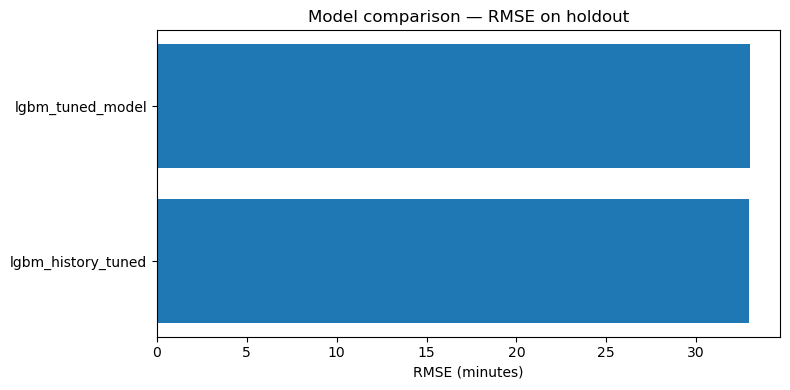

Saved plot: C:\Users\shail_u9zs758\analysis_outputs\model_comparison_rmse.png


In [10]:
# Cell 8 — Visual: bar chart RMSE comparison
if len(results) == 0:
    print("No model results to plot.")
else:
    dfm = res_df.copy().sort_values("RMSE", ascending=True)
    plt.figure(figsize=(8,4))
    plt.barh(dfm['model'], dfm['RMSE'])
    plt.xlabel("RMSE (minutes)")
    plt.title("Model comparison — RMSE on holdout")
    plt.tight_layout()
    plot_path = OUT_DIR / "model_comparison_rmse.png"
    plt.savefig(plot_path, dpi=200)
    plt.show()
    print("Saved plot:", plot_path)

Using best model: lgbm_history_tuned
Saved segmented errors by Area -> C:\Users\shail_u9zs758\analysis_outputs\segmented_errors_by_Area.csv


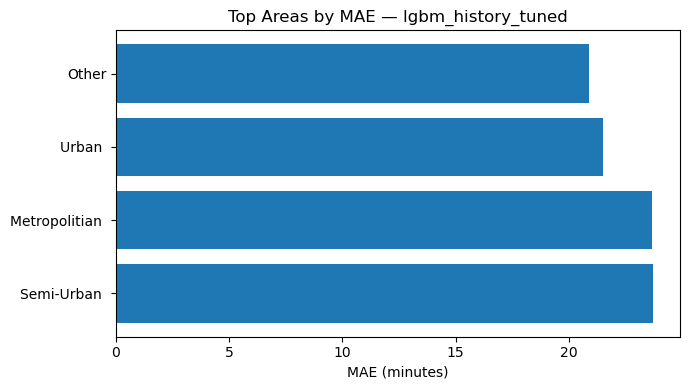

Saved plot: C:\Users\shail_u9zs758\analysis_outputs\segmented_errors_by_Area.png


In [11]:
# Cell 9 — Per-segment performance: errors by Area for best model
if len(res_df) > 0:
    best_model_name = res_df.iloc[0]['model']
    best_model_path = Path(res_df.iloc[0]['path'])
    print("Using best model:", best_model_name)
    preds_best = safe_predict(best_model_path, X_test)
    df_eval = test_df.copy()
    df_eval["predicted"] = preds_best
    df_eval["error_abs"] = (df_eval["predicted"] - df_eval[TARGET]).abs()
    # group by Area (if available)
    if "Area" in df_eval.columns:
        seg = df_eval.groupby("Area").agg(
            n=("error_abs","count"),
            MAE=("error_abs","mean")
        ).sort_values("MAE", ascending=False).reset_index()
        seg.to_csv(OUT_DIR / "segmented_errors_by_Area.csv", index=False)
        print("Saved segmented errors by Area ->", OUT_DIR / "segmented_errors_by_Area.csv")
        # plot top 10 areas by MAE
        topn = seg.head(10)
        plt.figure(figsize=(7,4))
        plt.barh(topn['Area'], topn['MAE'])
        plt.xlabel("MAE (minutes)")
        plt.title(f"Top Areas by MAE — {best_model_name}")
        plt.tight_layout()
        p = OUT_DIR / "segmented_errors_by_Area.png"
        plt.savefig(p, dpi=180)
        plt.show()
        print("Saved plot:", p)
    else:
        print("Column 'Area' not found in dataset; skipping segmented Area analysis.")

Computing SHAP for: lgbm_history_tuned
Saved SHAP top features CSV: C:\Users\shail_u9zs758\analysis_outputs\shap_best_model_top_features.csv


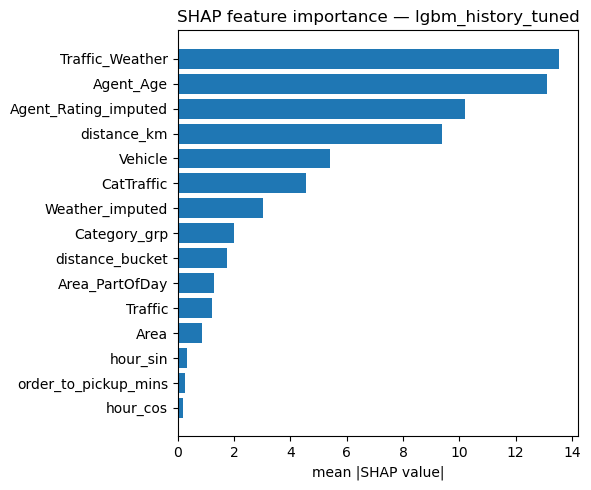

Saved SHAP plot: C:\Users\shail_u9zs758\analysis_outputs\shap_best_model_importance.png


In [12]:
# Cell 10 — SHAP summary for best model (if it's a tree model)
# This computes SHAP on a sample of the test rows to keep runtime reasonable.
try:
    import shap
    best_model_name = res_df.iloc[0]['model']
    best_model_path = Path(res_df.iloc[0]['path'])
    print("Computing SHAP for:", best_model_name)
    # load model object
    m = joblib.load(best_model_path) if best_model_path.exists() else None
    # For mlflow models, try load_model
    if m is None:
        try:
            m = mlflow.pyfunc.load_model(str(best_model_path))
        except Exception:
            m = None
    # Prepare sample
    sample_size = min(5000, X_test.shape[0])
    X_sample = X_test.sample(sample_size, random_state=42)
    # If model is tree-based (lightgbm), try TreeExplainer
    explainer = None
    if hasattr(m, "booster_") or "LGBMRegressor" in str(type(m)):
        explainer = shap.TreeExplainer(m)
    elif hasattr(m, "predict"):
        # try to find inner booster (if pyfunc wrapper)
        try:
            inner = getattr(m, "python_model", None)
            if inner is not None and hasattr(inner, "model"):
                explainer = shap.TreeExplainer(inner.model)
        except Exception:
            explainer = None
    if explainer is None:
        print("No compatible tree explainer found for this model — skipping SHAP.")
    else:
        sv = explainer.shap_values(X_sample)
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.abs(sv).mean(axis=0)
        shap_df = pd.DataFrame({"feature": X_sample.columns, "mean_abs_shap": mean_abs})
        shap_df = shap_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
        shap_df.to_csv(OUT_DIR / "shap_best_model_top_features.csv", index=False)
        print("Saved SHAP top features CSV:", OUT_DIR / "shap_best_model_top_features.csv")
        # plot top 15
        topk = shap_df.head(15).iloc[::-1]
        plt.figure(figsize=(6,5))
        plt.barh(topk['feature'], topk['mean_abs_shap'])
        plt.xlabel("mean |SHAP value|")
        plt.title(f"SHAP feature importance — {best_model_name}")
        plt.tight_layout()
        outplot = OUT_DIR / "shap_best_model_importance.png"
        plt.savefig(outplot, dpi=200)
        plt.show()
        print("Saved SHAP plot:", outplot)
except Exception as e:
    print("SHAP analysis skipped/failed:", e)

In [13]:
# Cell 11 — Final summary table & quick print
print("Models evaluated:", list(res_df['model']) if not res_df.empty else "none")
print("Comparison CSV:", OUT_DIR / "model_comparison_metrics.csv")
display(res_df)

Models evaluated: ['lgbm_history_tuned', 'lgbm_tuned_model']
Comparison CSV: C:\Users\shail_u9zs758\analysis_outputs\model_comparison_metrics.csv


,model,path,MAE,RMSE,R2,n_test
0,lgbm_history_tuned,C:\Users\shail_u9zs758\lgbm_history_tuned.joblib,23.125452,32.935771,0.597513,43739
1,lgbm_tuned_model,C:\Users\shail_u9zs758\lgbm_tuned_model.joblib,23.360993,33.018954,0.595477,43739
